# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка библиотек и константы

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score,
    mean_absolute_error,
)
from sklearn.model_selection import (
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler
)

from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [2]:
ALPHA = 0.05
CONFIDANCE_INTERVAL = 0.95
BUDGET = 10_000_000_000
PRICE_BARREL_MATERIALS = 450 
REVENUE_PER_UNIT_PRODUCT = 450_000
THRESHOLD_PROBABILITY_LOSSES = 2.5
BOOTSTRAP = 1_000

NUMBER_BEST_WELLS = 200
START_NUMBER_WELLS = 500

RANDOM_STATE = 42

## Функции и их тестирование

### Информация о датасете

In [3]:
def about_data(df: pd.DataFrame) -> None:
    """
    Выводит информацию о датасете:
        Первые пять строк датасета,
        Иформация о датасете (столбцы и количество данных),
        Описательная статистика данных.
    ----------
    Параметры:
        df: pd.DataFrame - Датасет.
        test = pd.DataFrame([1,2,3,4,5,6])
    Возращается:
        None
    Выводится:
        Первые пять строк датасета,
        Иформация о датасете (столбцы и количество данных),
        Описательная статистика данных.
    """
    print("Датасет")
    display(df.head())
    print("\n", "Информация о датасете")
    display(df.info())
    print("\n", "Описательная статитика")
    display(df.describe())
    print("\n", "Количество дубликатов")
    display(df.duplicated('id').sum())
    print("\n", "Корреляции признаков")
    display(df.corr())

In [4]:
test = pd.DataFrame([1,2,3,4,5,6], columns=['id'])

In [5]:
about_data(test)

Датасет


,id
0,1
1,2
2,3
3,4
4,5



 Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      6 non-null      int64
dtypes: int64(1)
memory usage: 176.0 bytes


None


 Описательная статитика


,id
count,6.000000
mean,3.500000
std,1.870829
min,1.000000
25%,2.250000
50%,3.500000
75%,4.750000
max,6.000000



 Количество дубликатов


0


 Корреляции признаков


,id
id,1.0


### Класс для работы с регрессией

In [6]:
class LinearRegressionData:
    """
    Класс для работы с линейной регрессией.
    ...
    Атрибуты
    --------
    features : pd.DataFrame 
        Признаки для обучения модели.
    target : pd.DataFrame 
        Целевые признаки для обучения модели.
    features_valid : pd.DataFrame = []
        Признаки для тестирования модели.
    target_valid: pd.DataFrame = []
        Целевые признаки для тестирования модели.
    Методы
    ------
    fit_line_regress(self) -> None:
        Обучение модели

    get_model(self) -> LinearRegression:
        Возвращает обученную модель

    model_estimates(self, y_true, y_pred) -> dict:
        Возращает словарь оценок модели

    get_coef_model(self) -> dict:
        Возвращает словарь с коэффициентами уравнения регресси

        Возвращает словарь с оценками модели по  данным
    predict_line_regression(self, features_valid = []) -> list:
        Возвращает предсказания по полученным данным

    prediction_evaluation(
        self, features_valid = [], target_valid = []
        ) -> dict:
        Предсказывает целевые значения по полученным данным
        
    data_valid_input_or_self(self,
        features_valid: pd.DataFrame = [],
        target_valid: pd.DataFrame = []
    ) -> pd.DataFrame, pd.DataFrame:
        Проверяет были ли ли переданы новые данные для предсказания

    standartize_data(self, features):
        Стандартизирует и возвращает данные внутри класса для работы модели

    """
    def __init__(
        self,
        features: pd.DataFrame,
        target: pd.DataFrame,
        features_valid: pd.DataFrame = [],
        target_valid: pd.DataFrame = [],
    ) -> None:
        
        import pandas as pd
        self.name_model = ''
        self.features = self.standartize_data(features)
        self.target = target
        if len(features_valid) > 0:
            self.features_valid = self.standartize_data(features_valid)
        else:
            self.features_valid  = features_valid
        self.target_valid = target_valid
        self.flag_fit_model = False

    def fit_line_regress(self) -> None:
        """
        Обучение модели по данным предаставленным при создании класса:
            features
            target
        """
        from sklearn.linear_model import LinearRegression
        self.reg = LinearRegression()
        self.reg.fit(self.features, self.target)
        self.flag_fit_model = True

    def get_model(self) -> LinearRegression:
        """
        Возвращает обученную модель на данных полученных 
        при создании экземпляра класса
            features
            target
        """
        if not self.flag_fit_model:
            self.fit_line_regress()
        return self.reg

    def predict_line_regression(
        self,
        features_valid: pd.DataFrame = []
    ) -> list:
        """
        Возвращает предсказания по полученным данным:
            features_valid
        """
        
        features, target = self.data_valid_input_or_self(
            features_valid, [1]
        )
        if not self.flag_fit_model:
            self.fit_line_regress()
        y_pred = self.reg.predict(features)
        return y_pred

    def get_coef_model(self) -> dict:
        """
        Возвращает словарь с коэффициентами уравнения регресси
        """
        if not self.flag_fit_model:
                self.fit_line_regress()
                
        res_dict = {
            "intercept": self.reg.intercept_[0]
        }
        list_coef = [elem for sublist in self.reg.coef_ for elem in sublist] 
        for i in range(len(list_coef)):
            res_dict[self.features.columns[i]] = list_coef[i]
        return res_dict

    def model_estimates(
        self,
        y_true: pd.DataFrame,
        y_pred: pd.DataFrame
    ) -> dict:
        """
        Возращает словарь оценок модели:
            MSE
            RMSE
            R2
            MAE
        """
        from sklearn.metrics import (
            mean_squared_error,
            mean_absolute_percentage_error,
            r2_score,
            mean_absolute_error
        )
        mse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=True)
        rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
        r_2 = r2_score(y_true=y_true, y_pred=y_pred)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
        return {
            "MSE": mse,
            "RMSE": rmse,
            "R2": r_2,
            "MAE": mae,
        }

    def prediction_evaluation(
        self,
        features_valid: pd.DataFrame = [],
        target_valid: pd.DataFrame = []
    ) -> dict:
        """
        Предсказывает целевые значения по полученным данным
        Возвращает словарь с оценками модели по  данным:
            features_valid
            target_valid
        """
        features, target = self.data_valid_input_or_self(features_valid, target_valid)
        if not self.flag_fit_model:
            self.fit_line_regress()
        y_pred = self.reg.predict(features)
        y_true = target
        return self.model_estimates(y_true, y_pred)

    
    def data_valid_input_or_self(
        self,
        features_valid: pd.DataFrame = [],
        target_valid: pd.DataFrame = []
    ):
        """
        Проверяет были ли переданы новые данные для предсказания:
            если да, возвращает новые данные, предварительно стандартизируя,
            если нет, возвращает данные хранящиеся в классе,
            если и те и другие пустые, выкидывает ошибку.
        """
        if (
            len(features_valid) != 0 and
            len(target_valid) != 0
        ):
            features_valid = self.standartize_data(features_valid)
            return features_valid, target_valid

        elif (
            len(self.features_valid) != 0 and
            len(self.target_valid) != 0
        ):
            return self.features_valid, self.target_valid
        
        else:
            raise Exception('Предоставьте данные для предсказания.')

    def standartize_data(self, features: pd.DataFrame) -> pd.DataFrame:
        """
        Стандартизирует данные внутри класса и возвращает стандартизированные данные.
        """
        from sklearn.preprocessing import (
            StandardScaler
        )
        columns = features.columns
        data = StandardScaler().fit_transform(features)
        return pd.DataFrame(data=data, columns=columns)


In [7]:
features = pd.DataFrame(
    [[76.6, 118.6, 200.8, 362.3, 648.9],
    [17.6, 128.6, 2550.8, 391.3, 613.9],
     [76.6, 118.6, 200.8, 362.3, 648.9],
    [17.6, 128.6, 2550.8, 391.3, 613.9],
    [17.6, 128.6, 2550.8, 391.3, 613.9]])
target = pd.DataFrame([10, 20, 40, 80, 160])
features_valid = pd.DataFrame(
    [[76.6, 118.6, 200.8, 362.3, 648.9],
    [77.6, 168.6, 270.8, 392.3, 678.9],
    [77.6, 168.6, 270.8, 392.3, 678.9],
    [77.6, 168.6, 270.8, 392.3, 678.9],
    [17.6, 128.6, 2550.8, 391.3, 613.9]])
target_valid = pd.DataFrame([10, 20, 40, 80, 160])

In [8]:
dl = LinearRegressionData(
    features,
    target,
    features_valid,
    target_valid
)

In [9]:
dl.prediction_evaluation(features_valid, target_valid)

{'MSE': 1507.4191523745637,
 'RMSE': 38.825496163919965,
 'R2': 0.4934747471859665,
 'MAE': 34.718493927941964}

In [10]:
dl.predict_line_regression(features_valid)

array([[37.62419223],
       [59.58602129],
       [59.58602129],
       [59.58602129],
       [93.61774389]])

In [11]:
dl.predict_line_regression()

array([[37.62419223],
       [59.58602129],
       [59.58602129],
       [59.58602129],
       [93.61774389]])

In [12]:
dl.get_coef_model()


{'intercept': 61.99999999999999,
 0: -6.0420746988651715,
 1: 6.042074698865175,
 2: 6.042074698865173,
 3: 6.042074698865174,
 4: -6.042074698865173}

### Расчёт прибыли по выбранным мместорождениям

In [13]:
def cacl_profit_wells(
    data: pd.Series,
    budget: float = 10_000_000_000, 
    revenue_per_unit_product: float = 450_000
) -> float:
    """
    Возращает суммарную прибыль по переданному списку месторождений
    ----------
    Параметры:
        data: pd.Series - Данные по продукции
        budget: float = 10_000_000_000 - Бюджет на разработку месторождений
        revenue_per_unit_product: float = 450 000 - Стоимость 
            единицы, указанной в столбце в data
    Возращается:
        sum_profit: float - Суммарная прибыль
    """
    data = pd.Series(data)
    income = data * revenue_per_unit_product
    profit = income.sum() - budget
    return profit


In [14]:
test = [100 for x in range(200)]
cacl_profit_wells(test)

-1000000000

In [15]:
test = [111 for x in range(200)]

In [16]:
cacl_profit_wells(test)

-10000000

In [17]:
test = [111.11111111111111 for x in range(200)]
cacl_profit_wells(test)

0.0

In [18]:
test = [111.20 for x in range(200)]
cacl_profit_wells(test)

8000000.0

In [19]:
test = [112 for x in range(200)]
cacl_profit_wells(test)

80000000

In [20]:
test = [150 for x in range(200)]
cacl_profit_wells(test)

3500000000

### Bootstrap для региона

In [21]:
def bootstrap_for_region(
    data_feauters: pd.DataFrame,
    true_product: pd.Series,
    RG: LinearRegressionData,
    budget: int = 10_000_000_000,
    start_number_wells: int = 500,
    count_bootstrap: int = 1000,
    number_best_wells: int = 200, 
) -> list:
    """
    Возращает список с прибылью по заданному количеству подвыборок.
    
    Проводит мжножество случайных отборов из предсказанных значений.
    Лучшие из отобранных отдает на предсказание  добычи.
    Предсказанное количество добытого сырья передается на рассчёт прибыли. 
    Прибыль по группе складывает в список. Приводит значения к млн. руб.
    Список возращает как результат.
    ----------
    Параметры:
        predict: pd.DataFrame - Признаки для предсказания добычи сырья.
        true_product: pd.Series - Реально добытое количество нефти.
        budget: int = 10_000_000_000 - Бюджет на разработку.
        start_number_wells: int = 500 - Начальный объём выборки 
            до отбора лучших.
        count_bootstrap: int = 1000 - Количество повторений.
        number_best_wells: int = 200 - Объём выборки лучших из 
            случайно выборки.
    Возращается:
        list_reg_profit: pd.Series - Список сумм прибыли по 
            выбокам полученным в ходе bootstrap в млн. руб.
    """
    
    list_reg_profit = []
    random_state_for_bootrstrap = np.random.RandomState(12345)
    data_feauters = data_feauters.reset_index(drop=True)
    true_product = true_product.reset_index(drop=True)

    for _ in tqdm(range(count_bootstrap)):
        
        temp = data_feauters.sample(
            n=start_number_wells,
            replace=True,
            random_state=random_state_for_bootrstrap
        )
        predict = pd.Series(
            RG.predict_line_regression(temp)
        )
        predict.index = temp.index
        predict = predict.sort_values(ascending=False)
        predict = predict.head(number_best_wells)
        
        best_true_product = true_product[predict.index]
        profit = cacl_profit_wells(best_true_product, budget)
        list_reg_profit.append(profit)

    return pd.Series(list_reg_profit) / 1_000_000

### Загрузка данных в датасет

In [22]:
def data_input_dataset(
    df: pd.DataFrame,
    number_region: int,
    list_reg_profit: list,
    min_conf_interval: float,
    max_conf_interval: float,
    BOOTSTRAP: float = 1000
) -> pd.DataFrame:
    """
    Вставляет данные по доверительному интервалу, среднему и 
    проценте убыточных итераций в дастасет.
    ----------
    Параметры:
        df: pd.DataFrame - Датасет, для вставки данных.
        number_region: int - Номер региона.
        list_reg_profit: list - Данные по распределнию прибыли.
        min_conf_interval: float - Нижний уровень дов. интервала
        max_conf_interval: float - Верхний уровень дов. интервала.
        BOOTSTRAP: float = 1000 - Количество итераций.
    Возращается:
        df: pd.DataFrame - Дополненый датасет.
    """
    df.loc[
        "reg_"+str(number_region), 'profit_' + str(min_conf_interval)
    ] = list_reg_profit.quantile(min_conf_interval) 

    df.loc[
        "reg_"+str(number_region), 'profit_' + str(max_conf_interval)
    ] = list_reg_profit.quantile(max_conf_interval)
    
    df.loc[
        "reg_"+str(number_region), 'mean_profit'
    ] = list_reg_profit.mean()
    
    df.loc[
        "reg_"+str(number_region), 'percentage_losses'
    ] = (
        ((list_reg_profit<0).sum() / BOOTSTRAP) * 100
    )
    
    return df

### Выделение значений в датасете

In [23]:
def allocation_target_region(series: pd.Series, col: str, threshold: float) -> str:
    """
    Возращает датасет с окрашенными строками. 
    Если в значении столбца col больше threshold - красный цвет.
    Если в значении столбца col меньше threshold - зеленый цвет.
    ----------
    Параметры:
        series: pd.Series - Строка датасета.
        col: str - Название ключевого столбца.
        threshold: float - Пороговый уровень разделения.
    Возращается:
        str - CSS строки.
    """
    if series[col] > threshold:
        return ['background-color: red']*len(series)
    else:
        return ['background-color: green']*len(series)


In [24]:
test = pd.DataFrame(
    data = [
        [150,20000],
        [1121,200],
        [11,21],
        [12,45],
        [1333,2],
        [100,50],
    ],
    columns=['target', 'predict']
)

In [25]:
test.style.apply(allocation_target_region, col='predict', threshold=50, axis=1)

,target,predict
0,150,20000
1,1121,200
2,11,21
3,12,45
4,1333,2
5,100,50


## Загрузка и подготовка данных

### Первое месторождение 

In [26]:
reg_1 = pd.read_csv("/datasets/geo_data_0.csv")

In [27]:
about_data(reg_1)

Датасет


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



 Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


 Описательная статитика


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



 Количество дубликатов


10


 Корреляции признаков


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


Имеется десять потворов, удалим, чтобы избежать ошибок

In [28]:
reg_1 = reg_1.drop_duplicates(subset=['id'])

Данные полные. Пропусков нет. Название столбцов адекватные. Разброс признаков адекватный. Были повторы - удалены.

### Второе месторождение 

In [29]:
reg_2 = pd.read_csv("/datasets/geo_data_1.csv")

In [30]:
about_data(reg_2)

Датасет


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



 Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


 Описательная статитика


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



 Количество дубликатов


4


 Корреляции признаков


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [31]:
reg_2 = reg_2.drop_duplicates(subset=['id'])

Данные полные. Пропусков нет. Название столбцов адекватные. Разброс признаков адекватный. Были повторы - удалены.

### Третье месторождение 

In [32]:
reg_3 = pd.read_csv("/datasets/geo_data_2.csv")

In [33]:
about_data(reg_3)

Датасет


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



 Информация о датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


 Описательная статитика


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838



 Количество дубликатов


4


 Корреляции признаков


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Имеется четыре потвора, удалим, чтобы избежать ошибок

In [34]:
reg_3 = reg_3.drop_duplicates(subset=['id'])

Данные полные. Пропусков нет. Название столбцов адекватные. Разброс признаков адекватный. Были повторы - удалены.

## Обучение и проверка модели

Датасет для сбора метрик моделей

In [35]:
evaluation_models_region = pd.DataFrame(
    columns=['reg_1', "reg_2", "reg_3"],
    index=["MSE", "RMSE", "R2", "MAE"]
)

Датасет для средних оценок продуктивности по регионам

In [36]:
mean_product_region = pd.DataFrame(
    index=['reg_1', "reg_2", "reg_3"],
    columns=["predict", "true"]
)

### Первое месторождение 

Разделим выборку и обучим модель

In [37]:
features_train_1, features_valid_1, train_target_1, target_valid_1 =  train_test_split(
    reg_1.drop(['id', 'product'], axis=1),
    reg_1['product'],
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [38]:
print('Размер обучающей выборки', features_train_1.shape)
print('Размер валидационной выборки', features_valid_1.shape)

Размер обучающей выборки (74992, 3)
Размер валидационной выборки (24998, 3)


In [39]:
RG_region_1 = LinearRegressionData(
    features_train_1 , train_target_1, features_valid_1, target_valid_1
)

Посмотрим на показатели модели

In [40]:
evaluation_models_region['reg_1'] = RG_region_1.prediction_evaluation().values()

In [41]:
for key, val in RG_region_1.prediction_evaluation().items():
    print(f"{key :<5.3}: {val:<5.3f}")

MSE  : 1420.136
RMS  : 37.685
R2   : 0.275
MAE  : 31.030


Показатели указывают на невысокую эффективность модели. Высокий уровень абсолютных ошибок и низкий коэффициент детерминации это подтверждают.

In [42]:
reg_1_predict = RG_region_1.predict_line_regression()
reg_1_traget = target_valid_1

In [43]:
mean_product_region.loc['reg_1', 'predict'] = reg_1_predict.mean()
mean_product_region.loc['reg_1', 'true'] = reg_1['product'].mean()

Предсказанное среднее

In [44]:
reg_1_predict.mean()

92.53665796438528

Истринное среднее

In [45]:
reg_1['product'].mean()

92.49968421774354

Средние близки. Модель справляется с поставленной задачей.

### Второе месторождение 

Разделим выборку и обучим модель

In [46]:
features_train_2, features_valid_2, train_target_2, target_valid_2 =  train_test_split(
    reg_2.drop(['id', 'product'], axis=1),
    reg_2['product'],
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [47]:
print('Размер обучающей выборки', features_train_2.shape)
print('Размер валидационной выборки', features_valid_2.shape)

Размер обучающей выборки (74997, 3)
Размер валидационной выборки (24999, 3)


In [48]:
RG_region_2 = LinearRegressionData(
    features_train_2 , train_target_2, features_valid_2, target_valid_2
)

Посмотрим на показатели модели

In [49]:
evaluation_models_region['reg_2'] = RG_region_2.prediction_evaluation().values()

In [50]:
for key, val in RG_region_2.prediction_evaluation().items():
    print(f"{key :<5.3}: {val:<5.3f}")

MSE  : 0.900
RMS  : 0.949
R2   : 1.000
MAE  : 0.763


Показатели указывают на высокую эффективность модели. Низкий уровень абсолютных ошибок и высокий коэффициент детерминации это подтверждают.

In [51]:
reg_2_predict = RG_region_2.predict_line_regression()
reg_2_traget = target_valid_2

In [52]:
mean_product_region.loc['reg_2', 'predict'] = reg_2_predict.mean()
mean_product_region.loc['reg_2', 'true'] = reg_2['product'].mean()

Предсказанное среднее

In [53]:
reg_2_predict.mean()


68.9040159205154

Истринное среднее

In [54]:
reg_2['product'].mean()

68.82391591804064

Среднии близки. Модель справляется с поставленной задачей.

### Третье месторождение 

Разделим выборку и обучим модель

In [55]:
features_train_3, features_valid_3, train_target_3, target_valid_3 =  train_test_split(
    reg_3.drop(['id', 'product'], axis=1),
    reg_3['product'],
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [56]:
print('Размер обучающей выборки', features_train_3.shape)
print('Размер валидационной выборки', features_valid_3.shape)

Размер обучающей выборки (74997, 3)
Размер валидационной выборки (24999, 3)


In [57]:
RG_region_3 = LinearRegressionData(
    features_train_3 , train_target_3, features_valid_3, target_valid_3
)

Посмотрим на показатели модели

In [58]:
evaluation_models_region['reg_3'] = RG_region_3.prediction_evaluation().values()

In [59]:
for key, val in RG_region_3.prediction_evaluation().items():
    print(f"{key :<5.3}: {val:<5.3f}")

MSE  : 1606.559
RMS  : 40.082
R2   : 0.195
MAE  : 32.831


Показатели указывают на невысокую эффективность модели. Высокий уровень абсолютных ошибок и низкий коэффициент детерминации это подтверждают.

In [60]:
reg_3_predict = RG_region_3.predict_line_regression()
reg_3_traget = target_valid_3

In [61]:
mean_product_region.loc['reg_3', 'predict'] = reg_3_predict.mean()
mean_product_region.loc['reg_3', 'true'] = reg_3['product'].mean()

Предсказанное среднее

In [62]:
reg_3_predict.mean()

94.91291058691559

Истринное среднее

In [63]:
reg_3['product'].mean()

94.99834211933378

Среднии близки. Модель справляется с поставленной задачей.

### Общее заключение по моделям

In [64]:
evaluation_models_region

,reg_1,reg_2,reg_3
MSE,1420.136401,0.900340,1606.558776
RMSE,37.684697,0.948863,40.081901
R2,0.274554,0.999574,0.194803
MAE,31.030018,0.763273,32.830531


Наиболее точной моделью является модель обученная на данных второго региона. Модели обученные на данных первого и третьего регионов показывают высокое число ошибок.

In [65]:
mean_product_region

,predict,true
reg_1,92.536658,92.499684
reg_2,68.904016,68.823916
reg_3,94.912911,94.998342


Средние предсказания продустивности моделей близки к иситинным значениям в регионах. Можно отметить, что наименьшая средняя добыча обнаружена во втором регионе.

## Подготовка к расчёту прибыли

Бюджет на одну скважину

In [66]:
budet_one_well = BUDGET / NUMBER_BEST_WELLS
budet_one_well

50000000.0

Минимальный объём сырья, для того, чтобы месторождение было безубыточным

In [67]:
min_volumes_product = budet_one_well / REVENUE_PER_UNIT_PRODUCT
min_volumes_product

111.11111111111111

In [68]:
min_volumes_product * 450_000

50000000.0

Минимальный объём добычи для рентабельной работы составляет - 111.11 тыс. баррелей.

In [69]:
mean_product_region

,predict,true
reg_1,92.536658,92.499684
reg_2,68.904016,68.823916
reg_3,94.912911,94.998342


Во всех регионах среднее количество добычи ниже, чем необходимое количество для безубыточной разработки.

## Расчёт прибыли и рисков 

### Датасет для сравнения регионов по бутстреп

In [70]:
df_profit = pd.DataFrame(
    index=['reg_1', 'reg_2', 'reg_3'],
    columns=['mean_profit']
)

### Алгоритм расчёта прибыли и риска

* Рассчитаем распределение прибыли по первому региону. Будем на основе признаков предсказывать продукцию, рассчитывать её стоимость. На основании суммарной стоимости оценим финансовый эффект региона. ДЛя удобства рзультаты будем представлятьв **млн. рублей**. 
* Риск будет оценен по нижней границе. Посмотрим, какое количество выборот даст убыточные результаты. Если это значение будет выше 2.5% от всех выборок, данный регион будет опасен для инвестиций.


Подобный алгоритм будет использован для всех регионов.

### Границы доверительного интервала

In [71]:
min_conf_interval = round((1 - CONFIDANCE_INTERVAL) / 2, 3)
max_conf_interval = round((1 + CONFIDANCE_INTERVAL) / 2, 3)

### Словарь с данным по прибылям регионов

In [72]:
dict_region_profit = {}

### Первое месторождение 

Расчитываем распределение прибыли

In [73]:
list_reg_1_profit = bootstrap_for_region(
    features_valid_1,
    reg_1_traget,
    RG_region_1
)

100%|██████████| 1000/1000 [00:05<00:00, 186.66it/s]


Складываем данные по региону в датасет

In [74]:
dict_region_profit['region_1'] = list_reg_1_profit
df_profit = data_input_dataset(
    df_profit,
    1,
    list_reg_1_profit,
    min_conf_interval,
    max_conf_interval
)

In [75]:
df_profit

,mean_profit,profit_0.025,profit_0.975,percentage_losses
reg_1,416.910061,-90.244332,933.632539,5.8
reg_2,NaN,NaN,NaN,NaN
reg_3,NaN,NaN,NaN,NaN


### Второе месторождение 

Расчитываем распределение прибыли

In [76]:
list_reg_2_profit = bootstrap_for_region(
    features_valid_2,
    reg_2_traget,
    RG_region_2
)

100%|██████████| 1000/1000 [00:05<00:00, 183.59it/s]


Складываем данные по региону в датасет

In [77]:
dict_region_profit['region_2'] = list_reg_2_profit
df_profit = data_input_dataset(
    df_profit,
    2,
    list_reg_2_profit,
    min_conf_interval,
    max_conf_interval
)

In [78]:
df_profit

,mean_profit,profit_0.025,profit_0.975,percentage_losses
reg_1,416.910061,-90.244332,933.632539,5.8
reg_2,432.016439,51.741836,863.042250,1.0
reg_3,NaN,NaN,NaN,NaN


### Третье месторождение 

Расчитываем распределение прибыли

In [79]:
list_reg_3_profit = bootstrap_for_region(
    features_valid_3,
    reg_3_traget,
    RG_region_3
)

100%|██████████| 1000/1000 [00:05<00:00, 176.50it/s]


Складываем данные по региону в датасет

In [80]:
dict_region_profit['region_3'] = list_reg_3_profit
df_profit = data_input_dataset(
    df_profit,
    3,
    list_reg_3_profit,
    min_conf_interval,
    max_conf_interval
)

In [81]:
df_profit

,mean_profit,profit_0.025,profit_0.975,percentage_losses
reg_1,416.910061,-90.244332,933.632539,5.8
reg_2,432.016439,51.741836,863.042250,1.0
reg_3,356.984291,-186.256155,892.099106,8.8


## Общий вывод

In [82]:
threshold_estimation = df_profit['percentage_losses'] > THRESHOLD_PROBABILITY_LOSSES
df_profit['exceeding_threshold'] = threshold_estimation
df_profit['exceeding_threshold'] = df_profit['exceeding_threshold'].where(
    threshold_estimation, "Ниже порога"
)
df_profit['exceeding_threshold'] = df_profit['exceeding_threshold'].where(
    ~threshold_estimation, "Выше порога"
)

In [83]:
df_profit.style.apply(
    allocation_target_region,
    col='percentage_losses',
    threshold=THRESHOLD_PROBABILITY_LOSSES,
    axis=1
)

,mean_profit,profit_0.025,profit_0.975,percentage_losses,exceeding_threshold
reg_1,416.910061,-90.244332,933.632539,5.800000,Выше порога
reg_2,432.016439,51.741836,863.042250,1.000000,Ниже порога
reg_3,356.984291,-186.256155,892.099106,8.800000,Выше порога


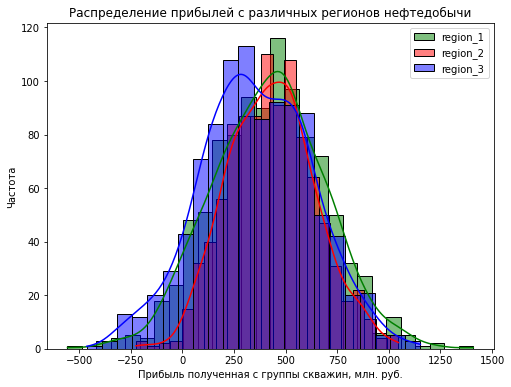

In [84]:
fig = plt.figure(figsize=(8, 6))
colors = ['g', 'r', 'b']
count = 0
for key, item in dict_region_profit.items():
    sns.histplot(
        data=item,
        kde=True,
        color=colors[count],
        label=key
    )
    count += 1
plt.legend()
plt.title("Распределение прибылей с различных регионов нефтедобычи")
plt.xlabel("Прибыль полученная с группы скважин, млн. руб.")
plt.ylabel("Частота")
plt.show()

* Все регионы в среднем являются прибыльными. Но так де в каждом имеются убыточные значения. Наименьшая вероятность получить убыточные значения во втором регионе.
* Доверие к модели во **втором регионе** самое высокое среди изученных. Модели в остальных регионах показывают выские разброс значений при оценке продуктивности и, следовательно, могут сильно ошибаться при оценке продукции.
* Наиболее оптимальным регионом для инвестиций будет **второй регион**, так как в целом его распределение смещено к более высоким областям прибыли. И данный регион имеет более низкий уровень вероятности получить убыль. Среднее значение прибыли второго региона выше, чем у других, и составляет - 432.016 млн. руб.
